In [1]:
import dask_awkward as dak
import awkward as ak
import numpy as np
import matplotlib.pyplot as plt
from distributed import LocalCluster, Client
import dask.dataframe as dd
import pandas as pd

client = Client(n_workers=50,  threads_per_worker=1, processes=True, memory_limit='10 GiB')


/depot/cms/kernels/coffea2024/lib/python3.10/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 36029 instead
  warnings.warn(


In [2]:

"""
testing for any difference between using OmegaConfig's parameters.yaml vs older parameters.json file
There shouldn't be any differences, but first time using OmegaConfig, so doesn't hurt to check
"""


sample = "dy_M-100To200"
full_load_path = f"/depot/cms/users/yun79/hmm/copperheadV1clean/test_validation_bigV1_18May2024_minDetaDPhiFixed/stage1_output/2018/{sample}/*.parquet"

df_dy = dd.read_parquet(full_load_path)

sample = "ggh_powheg"
full_load_path = f"/depot/cms/users/yun79/hmm/copperheadV1clean/test_validation_bigV1_18May2024_minDetaDPhiFixed/stage1_output/2018/{sample}/*.parquet"

df_ggh = dd.read_parquet(full_load_path)

# # using pre-exisitng code for quick validation
df_new=df_dy
df_old=df_ggh

In [3]:
A = pd.DataFrame([1,2,3],columns=["test"])
B = pd.DataFrame([0,1,6],columns=["test"])
A.where((B.test < A.test), B)

,test
0,1
1,2
2,6


In [4]:
df_dy.mu1_pt

Dask Series Structure:
npartitions=2205
    float64
        ...
     ...   
        ...
        ...
Dask Name: getitem, 2 expressions
Expr=ReadParquetFSSpec(a591213)['mu1_pt']

In [5]:
binning_map = {
    "dimuon_cos_theta_cs" : [-1, 1, 101],
    "dimuon_phi_cs" :[-3.1415, 3.1415, 101],
    "dimuon_cos_theta_cs_pisa" : [-1, 1, 101],
    "dimuon_phi_cs_pisa" :[-3.1415, 3.1415, 101],
    # "dimuon_phi_cs" :[-5, 5, 101],
}

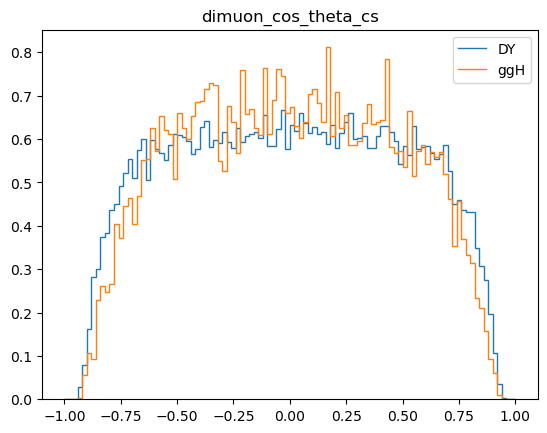

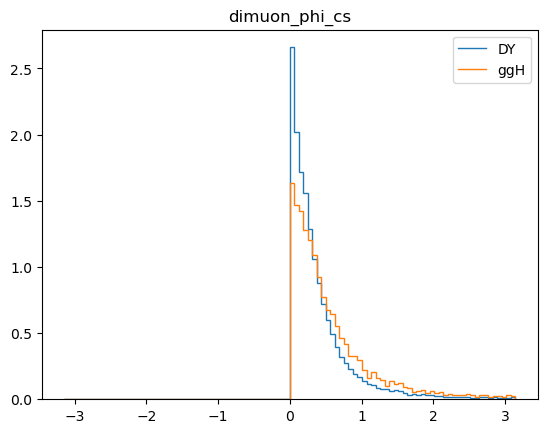

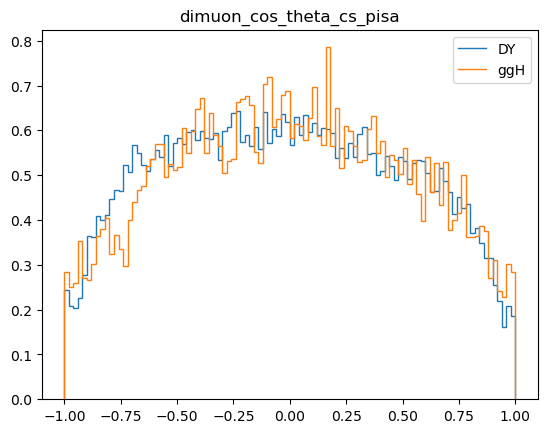

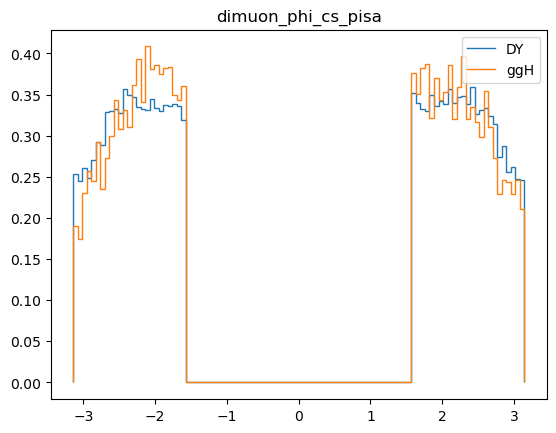

In [6]:
# var = "mu1_pt"
# var = "dimuon_mass"
# var = "jet1_pt"
# variables = ["mu1_pt", "mu2_pt", "dimuon_mass"]
variables = [
            "dimuon_cos_theta_cs","dimuon_phi_cs", 
        "dimuon_cos_theta_cs_pisa","dimuon_phi_cs_pisa"
            ]


region = df_new.region 
# weights_new = ak.to_numpy(df_new["weights"].compute())
region = ((region =="h-peak") | (region =="h-sidebands")).astype(int)
weights_new = df_new["wgt_nominal"]
btag_cut_new =(df_new["nBtagLoose_nominal"] >= 2) | (df_new["nBtagMedium_nominal"] >= 1)
vbf_cut = (df_new.jj_mass_nominal > 400) & (df_new.jj_dEta_nominal > 2.5) & (df_new.jet1_pt_nominal > 35)
vbf_cut.fillna(False)
weights_new = (weights_new*region * (~vbf_cut) * btag_cut_new).compute()

region = df_old.region 
region = ((region =="h-peak") | (region =="h-sidebands")).astype(int)
weights_old = df_old["wgt_nominal"]
btag_cut_old =(df_old["nBtagLoose_nominal"] >= 2) | (df_old["nBtagMedium_nominal"] >= 1)
vbf_cut = (df_old.jj_mass_nominal > 400) & (df_old.jj_dEta_nominal > 2.5) & (df_old.jet1_pt_nominal > 35)
vbf_cut.fillna(False)
weights_old = (weights_old*region * (~vbf_cut) * btag_cut_old).compute()

for var in variables:
    kin = var.split("_")[-1]
    # binning = np.linspace(*[25, 300, 50])
    binning = np.linspace(*binning_map[var])
    # old_len = ak.num(df_old["mu1_pt"].compute(), axis=0)
    # new_len = ak.num(df_new["mu1_pt"].compute(), axis=0)
    # new_weights = np.ones(new_len)
    # new_weights = new_weights*old_len/new_len

    var_old = var
    hist_old, edges = np.histogram(df_old[var_old].compute(), bins=binning ,weights=weights_old, density=True)
    # hist_old, edges = np.histogram(df_old[var+"_nominal"].compute(), bins=binning )
    
    # hist_new, _= np.histogram(df_new[region_cut][var].compute(), bins=binning , weights=new_weights)
    hist_new, _= np.histogram(df_new[var].compute(), bins=binning ,weights=weights_new, density=True)
    
    plt.stairs(hist_new, edges, label = "DY")
    plt.stairs(hist_old, edges, label = "ggH")
    plt.legend(loc="upper right")
    plt.title(var)
    plt.show()
    # plt.stairs((hist_new-hist_old), edges)
    # plt.title(var+" diff")
    # plt.hlines(0, min(edges), max(edges), colors='red', linestyles="dashed")
    # plt.show()
    # plt.stairs((hist_new-hist_old)/hist_old, edges)
    # plt.title(f"{sample} {var}"+" relative diff")
    # plt.hlines(0, min(edges), max(edges), colors='red', linestyles="dashed")
    # plt.show()

In [7]:
binning_map = {
    "dimuon_cos_theta_cs" : [0, 1, 101],
    "dimuon_phi_cs" :[0, 9, 101],
    # "dimuon_phi_cs" :[-5, 5, 101],
}

In [8]:
# var = "mu1_pt"
# var = "dimuon_mass"
# var = "jet1_pt"
# variables = ["mu1_pt", "mu2_pt", "dimuon_mass"]
variables = ["dimuon_cos_theta_cs","dimuon_phi_cs", 
            ]



# weights_new = ak.to_numpy(df_new["weights"].compute())
region = df_new.h_sidebands | df_new.h_peak 
weights_new = df_new["weights"]
btag_cut_new =(df_new["nBtagLoose"] >= 2) | (df_new["nBtagMedium"] >= 1)
weights_new = (weights_new*region * (~df_new["vbf_cut"]) * btag_cut_new).compute()


region = df_old.h_sidebands | df_old.h_peak 
weights_old = df_old["weights"]
btag_cut_old =(df_old["nBtagLoose"] >= 2) | (df_old["nBtagMedium"] >= 1)
weights_old = (weights_old*region * (~df_old["vbf_cut"]) * btag_cut_old).compute()

for var in variables:
    kin = var.split("_")[-1]
    # binning = np.linspace(*[25, 300, 50])
    binning = np.linspace(*binning_map[var])
    # old_len = ak.num(df_old["mu1_pt"].compute(), axis=0)
    # new_len = ak.num(df_new["mu1_pt"].compute(), axis=0)
    # new_weights = np.ones(new_len)
    # new_weights = new_weights*old_len/new_len

    var_old = var
    hist_old, edges = np.histogram(df_old[var_old].compute()**2, bins=binning ,weights=weights_old, density=True)
    # hist_old, edges = np.histogram(df_old[var+"_nominal"].compute(), bins=binning )
    
    # hist_new, _= np.histogram(df_new[region_cut][var].compute(), bins=binning , weights=new_weights)
    hist_new, _= np.histogram(df_new[var].compute()**2, bins=binning ,weights=weights_new, density=True)
    
    plt.stairs(hist_new, edges, label = "DY")
    plt.stairs(hist_old, edges, label = "ggH")
    plt.legend(loc="upper right")
    plt.title(var)
    plt.show()
    # plt.stairs((hist_new-hist_old), edges)
    # plt.title(var+" diff")
    # plt.hlines(0, min(edges), max(edges), colors='red', linestyles="dashed")
    # plt.show()
    # plt.stairs((hist_new-hist_old)/hist_old, edges)
    # plt.title(f"{sample} {var}"+" relative diff")
    # plt.hlines(0, min(edges), max(edges), colors='red', linestyles="dashed")
    # plt.show()

AttributeError: 'DataFrame' object has no attribute 'h_sidebands'

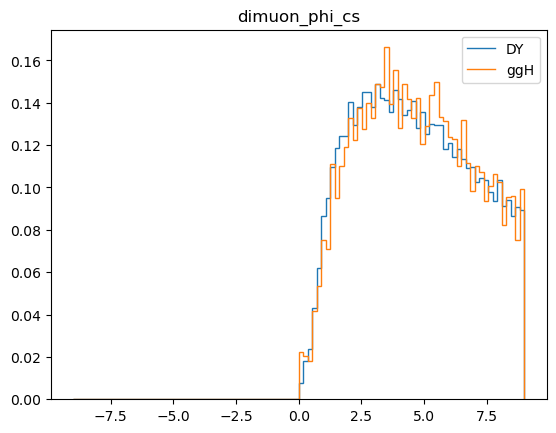

In [12]:
binning = np.linspace(*[-9, 9, 101])

theta = np.arccos(df_old["dimuon_cos_theta_cs"].compute())
phi = ak.to_numpy(df_old["dimuon_phi_cs"].compute())
hist_old, edges = np.histogram((theta**2 + phi**2), bins=binning ,weights=weights_old, density=True)

theta = np.arccos(df_new["dimuon_cos_theta_cs"].compute())
phi = ak.to_numpy(df_new["dimuon_phi_cs"].compute())
hist_new, _= np.histogram((theta**2 + phi**2), bins=binning ,weights=weights_new, density=True)

plt.stairs(hist_new, edges, label = "DY")
plt.stairs(hist_old, edges, label = "ggH")
plt.legend(loc="upper right")
plt.title(var)
plt.show()

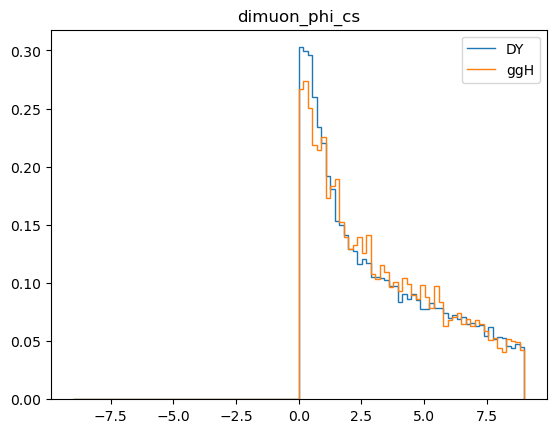

In [13]:
binning = np.linspace(*[-9, 9, 101])

costheta = ak.to_numpy(df_old["dimuon_cos_theta_cs"].compute())
phi = ak.to_numpy(df_old["dimuon_phi_cs"].compute())
hist_old, edges = np.histogram((costheta**2 + phi**2), bins=binning ,weights=weights_old, density=True)

costheta = ak.to_numpy(df_new["dimuon_cos_theta_cs"].compute())
phi = ak.to_numpy(df_new["dimuon_phi_cs"].compute())
hist_new, _= np.histogram((costheta**2 + phi**2), bins=binning ,weights=weights_new, density=True)

plt.stairs(hist_new, edges, label = "DY")
plt.stairs(hist_old, edges, label = "ggH")
plt.legend(loc="upper right")
plt.title(var)
plt.show()

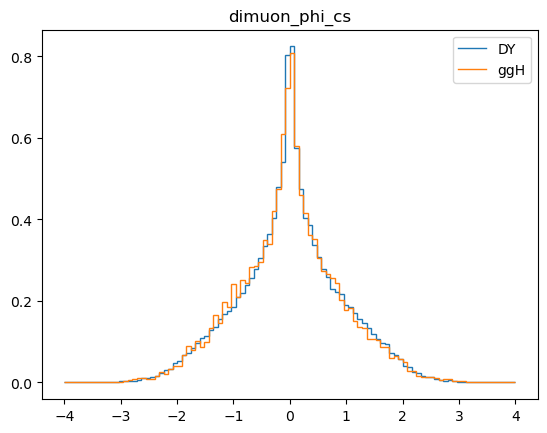

In [12]:
binning = np.linspace(*[-4, 4, 101])

costheta = ak.to_numpy(df_old["dimuon_cos_theta_cs"].compute())
phi = ak.to_numpy(df_old["dimuon_phi_cs"].compute())
hist_old, edges = np.histogram((costheta*phi), bins=binning ,weights=weights_old, density=True)

costheta = ak.to_numpy(df_new["dimuon_cos_theta_cs"].compute())
phi = ak.to_numpy(df_new["dimuon_phi_cs"].compute())
hist_new, _= np.histogram(costheta*phi, bins=binning ,weights=weights_new, density=True)

plt.stairs(hist_new, edges, label = "DY")
plt.stairs(hist_old, edges, label = "ggH")
plt.legend(loc="upper right")
plt.title(var)
plt.show()

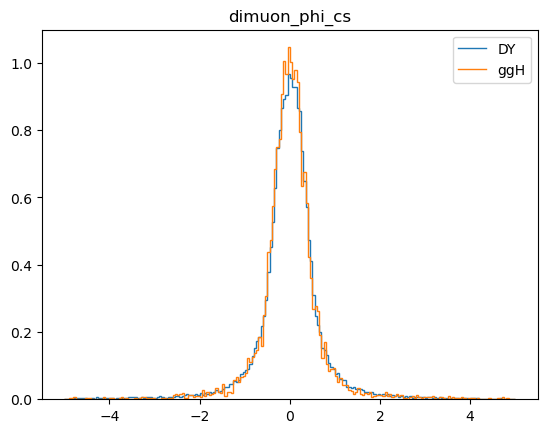

In [13]:
binning = np.linspace(*[-5, 5, 201])

costheta = ak.to_numpy(df_old["dimuon_cos_theta_cs"].compute())
phi = ak.to_numpy(df_old["dimuon_phi_cs"].compute())
hist_old, edges = np.histogram((costheta/phi), bins=binning ,weights=weights_old, density=True)

costheta = ak.to_numpy(df_new["dimuon_cos_theta_cs"].compute())
phi = ak.to_numpy(df_new["dimuon_phi_cs"].compute())
hist_new, _= np.histogram(costheta/phi, bins=binning ,weights=weights_new, density=True)

plt.stairs(hist_new, edges, label = "DY")
plt.stairs(hist_old, edges, label = "ggH")
plt.legend(loc="upper right")
plt.title(var)
plt.show()